# DNN 二分类模型的多层次实现

In [7]:
import tensorflow as tf

# 打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    
    tf.print("=========="*8+timestring)

# 准备数据

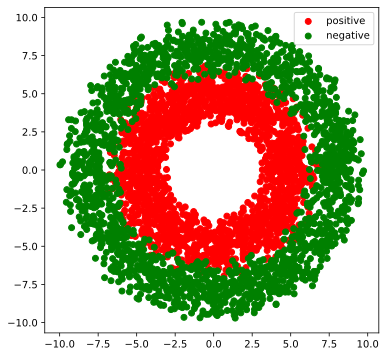

In [26]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# 正负样本数量
n_positive,n_negative = 2000,2000
n = n_positive+n_negative

# 生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

# 生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

# 汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


# 可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);


In [2]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[ 2.264682   5.9122624]
 [-1.8424052  7.076006 ]
 [ 1.3367271 -3.909252 ]
 [-6.9510794  4.5522437]
 [-8.4665985  0.6560081]
 [ 6.0963817 -6.0818596]
 [ 9.18274    1.198159 ]
 [-0.5775056 -3.8282325]
 [-3.3482847 -3.5457916]
 [-4.196395  -5.4652314]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [1.]
 [0.]], shape=(10, 1), dtype=float32)


# 低阶 API

## 定义模型

此处范例我们利用tf.Module来组织模型变量，关于tf.Module的较详细介绍参考本书第四章最后一节: Autograph和tf.Module。



In [3]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)])  
    def loss_func(self,y_true,y_pred):  
        #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return  tf.reduce_mean(bce)
    
    # 评估指标(准确率)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)]) 
    def metric_func(self,y_true,y_pred):
        y_pred = tf.where(y_pred>0.5,tf.ones_like(y_pred,dtype = tf.float32),
                          tf.zeros_like(y_pred,dtype = tf.float32))
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc
    
model = DNNModel()

In [4]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 0.583379745
init metric 0.6


In [5]:
print(len(model.trainable_variables))


6


## 训练模型

In [8]:
##使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    
    # 正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions) 
        
    # 反向传播求梯度
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 执行梯度下降
    for p, dloss_dp in zip(model.trainable_variables,grads):
        p.assign(p - 0.001*dloss_dp)
        
    # 计算评估指标
    metric = model.metric_func(labels,predictions)
    
    return loss, metric


def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,100):
            loss,metric = train_step(model,features,labels)
        if epoch%100==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)
        

train_model(model,epochs = 600)

================================================================================18:46:18
epoch = 100 loss =  0.59955734 accuracy =  0.61
================================================================================18:46:21
epoch = 200 loss =  0.501888871 accuracy =  0.74
================================================================================18:46:25
epoch = 300 loss =  0.386652708 accuracy =  0.79
================================================================================18:46:29
epoch = 400 loss =  0.322410315 accuracy =  0.81
================================================================================18:46:33
epoch = 500 loss =  0.31935212 accuracy =  0.89
================================================================================18:46:37
epoch = 600 loss =  0.347357213 accuracy =  0.83


## 结果展示

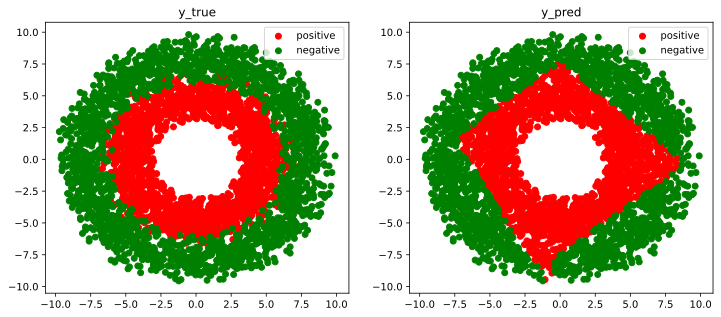

In [9]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

# 中阶 API

## 定义模型

In [11]:
from tensorflow.keras import layers,losses,metrics,optimizers

# 构建输入数据管道
ds = tf.data.Dataset.from_tensor_slices((X,Y)) \
     .shuffle(buffer_size = 4000).batch(100) \
     .prefetch(tf.data.experimental.AUTOTUNE) 

class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.dense1 = layers.Dense(4,activation = "relu") 
        self.dense2 = layers.Dense(8,activation = "relu")
        self.dense3 = layers.Dense(1,activation = "sigmoid")

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y
    
model = DNNModel()
model.loss_func = losses.binary_crossentropy
model.metric_func = metrics.binary_accuracy
model.optimizer = optimizers.Adam(learning_rate=0.001)

In [12]:
# 测试模型结构
(features,labels) = next(ds.as_numpy_iterator())

predictions = model(features)

loss = model.loss_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))
metric = model.metric_func(tf.reshape(labels,[-1]),tf.reshape(predictions,[-1]))

tf.print("init loss:", loss)
tf.print("init metric", metric)

init loss: 0.920945883
init metric 0.49


## 训练模型

In [16]:
#使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
        grads = tape.gradient(loss,model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads,model.trainable_variables))
    
    metric = model.metric_func(tf.reshape(labels,[-1]), tf.reshape(predictions,[-1]))
    
    return loss,metric

# 测试train_step效果
features,labels = next(ds.as_numpy_iterator())
train_step(model,features,labels)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.1473237>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.94>)

In [17]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        loss, metric = tf.constant(0.0),tf.constant(0.0)
        for features, labels in ds:
            loss,metric = train_step(model,features,labels)
        if epoch%10==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ",metric)
            
train_model(model,epochs = 60)

================================================================================18:52:24
epoch = 10 loss =  0.16607 accuracy =  0.93
================================================================================18:52:24
epoch = 20 loss =  0.16672878 accuracy =  0.92
================================================================================18:52:25
epoch = 30 loss =  0.0679109767 accuracy =  0.99
================================================================================18:52:25
epoch = 40 loss =  0.199062899 accuracy =  0.9
================================================================================18:52:26
epoch = 50 loss =  0.0969291702 accuracy =  0.96
================================================================================18:52:26
epoch = 60 loss =  0.0761641189 accuracy =  0.97


## 结果展示



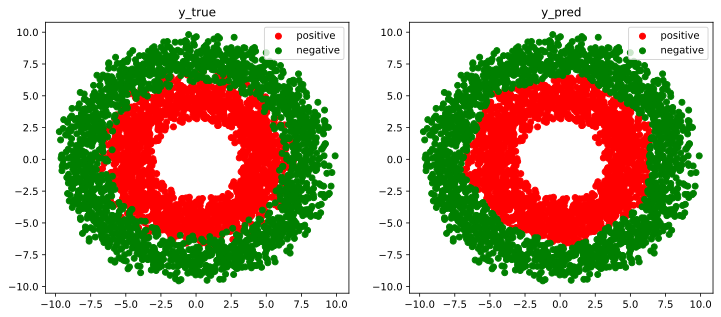

In [18]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");

# 高阶 API

In [20]:
from tensorflow.keras import models,layers,losses,metrics,optimizers


## 定义模型

In [27]:
ds_train = tf.data.Dataset.from_tensor_slices((X[0:n*3//4,:],Y[0:n*3//4,:])) \
     .shuffle(buffer_size = 1000).batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

ds_valid = tf.data.Dataset.from_tensor_slices((X[n*3//4:,:],Y[n*3//4:,:])) \
     .batch(20) \
     .prefetch(tf.data.experimental.AUTOTUNE) \
     .cache()

In [28]:
tf.keras.backend.clear_session()

class DNNModel(models.Model):
    def __init__(self):
        super(DNNModel, self).__init__()
        
    def build(self,input_shape):
        self.dense1 = layers.Dense(4,activation = "relu",name = "dense1") 
        self.dense2 = layers.Dense(8,activation = "relu",name = "dense2")
        self.dense3 = layers.Dense(1,activation = "sigmoid",name = "dense3")
        super(DNNModel,self).build(input_shape)
 
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def call(self,x):
        x = self.dense1(x)
        x = self.dense2(x)
        y = self.dense3(x)
        return y

model = DNNModel()
model.build(input_shape =(None,2))

model.summary()

Model: "dnn_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense1 (Dense)               multiple                  12        
_________________________________________________________________
dense2 (Dense)               multiple                  40        
_________________________________________________________________
dense3 (Dense)               multiple                  9         
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________


## 训练模型

In [29]:
### 自定义训练循环

optimizer = optimizers.Adam(learning_rate=0.01)
loss_func = tf.keras.losses.BinaryCrossentropy()

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_metric = tf.keras.metrics.BinaryAccuracy(name='train_accuracy')

valid_loss = tf.keras.metrics.Mean(name='valid_loss')
valid_metric = tf.keras.metrics.BinaryAccuracy(name='valid_accuracy')


@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = loss_func(labels, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

    train_loss.update_state(loss)
    train_metric.update_state(labels, predictions)

@tf.function
def valid_step(model, features, labels):
    predictions = model(features)
    batch_loss = loss_func(labels, predictions)
    valid_loss.update_state(batch_loss)
    valid_metric.update_state(labels, predictions)
    

def train_model(model,ds_train,ds_valid,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in ds_train:
            train_step(model,features,labels)

        for features, labels in ds_valid:
            valid_step(model,features,labels)

        logs = 'Epoch={},Loss:{},Accuracy:{},Valid Loss:{},Valid Accuracy:{}'
        
        if  epoch%100 ==0:
            printbar()
            tf.print(tf.strings.format(logs,
            (epoch,train_loss.result(),train_metric.result(),valid_loss.result(),valid_metric.result())))
        
        train_loss.reset_states()
        valid_loss.reset_states()
        train_metric.reset_states()
        valid_metric.reset_states()

train_model(model,ds_train,ds_valid,1000)

================================================================================18:57:18
Epoch=100,Loss:0.0912057608,Accuracy:0.963666677,Valid Loss:0.132912934,Valid Accuracy:0.943
================================================================================18:57:33
Epoch=200,Loss:0.0884640366,Accuracy:0.967333317,Valid Loss:0.114554435,Valid Accuracy:0.951
================================================================================18:57:48
Epoch=300,Loss:0.0875486732,Accuracy:0.967333317,Valid Loss:0.117411047,Valid Accuracy:0.951
================================================================================18:58:02
Epoch=400,Loss:0.0868558362,Accuracy:0.967666686,Valid Loss:0.118614584,Valid Accuracy:0.952
================================================================================18:58:17
Epoch=500,Loss:0.0864511281,Accuracy:0.967666686,Valid Loss:0.119248249,Valid Accuracy:0.952
================================================================================18:58:32
E

## 结果展示

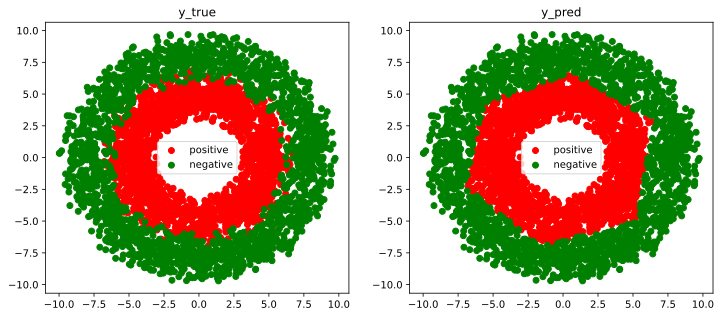

In [30]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
ax1.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0].numpy(),Xp_pred[:,1].numpy(),c = "r")
ax2.scatter(Xn_pred[:,0].numpy(),Xn_pred[:,1].numpy(),c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");